In [6]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils
from aldiscore import ROOT, RSTATE

from aldiscore.prediction.predictor import DifficultyPredictor


In [ ]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, drop_df, labels = utils.load_features(
    data_dir,
    exclude_features=["is_dna", "num_seqs", "seq_length", "10-mer_js", "13-mer_js"],
)
# feat_df.columns = clean_feat_names

print(feat_df.shape)
print(drop_df.shape)
print(labels.shape)

Dropping 0 NaN rows...
Index(['mean'], dtype='object')
(11431, 361)
(11431, 21)
(11431,)


## Performance report development

In [ ]:
from sklearn.model_selection import RepeatedKFold

# For 10 folds
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=0)
results = []
for train_idx, test_idx in rkf.split(feat_df, labels):
    X_train = feat_df.iloc[train_idx]
    y_train = labels.iloc[train_idx]
    X_test = feat_df.iloc[test_idx]
    y_test = labels.iloc[test_idx]
    # Run optuna search
    model = utils.optuna_search(
        X_train,
        y_train,
        early_stopping=25,
        n_trials=2,
        n_estimators=25,
        n_jobs=2,
    )
    # train model
    model.fit(X_train, y_train)
    # report performance on held-out fold (RMSE; R^2, MAE)
    out = utils.compute_metrics(model, X_test, y_test)
    out = pd.concat([out, pd.DataFrame([model.get_params()])], axis=1)
    results.append(out)

result_df = pd.concat(results, axis=0, ignore_index=True)
out_path = (
    ROOT.parent
    / "logs"
    / "reporting"
    / f"report_{np.random.randint(100000,999999)}.parquet"
)
result_df.to_parquet(out_path)
print(out_path)
print(result_df)

Best trial: 0. Best value: 0.136772: 100%|██████████| 2/2 [00:13<00:00,  6.75s/it]


/hits/fast/cme/bodynems/aldiscore/logs/reporting/report_807417.parquet
     RMSE     MAE     R^2    CORR boosting_type class_weight  \
0  0.1652  0.1260  0.1999  0.9291          gbdt         None   
1  0.1658  0.1263  0.1920  0.9456          gbdt         None   
2  0.0809  0.0604  0.8074  0.9536          gbdt         None   
3  0.1358  0.1028  0.4597  0.9485          gbdt         None   

   colsample_bytree importance_type  learning_rate  max_depth  ...  \
0          0.022303            gain       0.006422         -1  ...   
1          0.028949            gain       0.005195         -1  ...   
2          0.126182            gain       0.047585         -1  ...   
3          0.368763            gain       0.014413         -1  ...   

    objective  random_state  reg_alpha  reg_lambda  subsample  \
0  regression          None   0.002304    0.002355   0.404058   
1  regression          None   0.007816    0.008080   0.709696   
2  regression          None   0.000012    0.000050   0.660384 

In [2]:
perf_df = pd.read_parquet(
    "/hits/fast/cme/bodynems/aldiscore/logs/reporting/report_399991.parquet"
)
print(perf_df.shape)
print(
    perf_df.iloc[:, :4]
    .astype(float)
    .aggregate(["mean", "std"], axis=0)
    .round(4)
    .to_latex(float_format="%.4f")
)

(20, 26)
\begin{tabular}{lrrrr}
\toprule
 & RMSE & MAE & R^2 & CORR \\
\midrule
mean & 0.0425 & 0.0253 & 0.9466 & 0.9730 \\
std & 0.0019 & 0.0012 & 0.0054 & 0.0028 \\
\bottomrule
\end{tabular}



In [15]:
col_mapping = {
    "n_estimators": "num_iterations",
    "colsample_bytree": "feature_fraction",
    "colsample_bynode": "feature_fraction_bynode",
    "learning_rate": "learning_rate",
    "min_data": "min_child_samples",
    "num_leaves": "num_leaves",
    "lambda_l1": "reg_alpha",
    "lambda_l2": "reg_lambda",
    "subsample": "bagging_fraction",
}
col_mapping = dict(zip(col_mapping.values(), col_mapping.keys()))

In [19]:
unique_mask = perf_df.apply(lambda col: len(col.unique()), axis=0) > 1
cols = perf_df.columns.to_list()
cols.remove("n_estimators")
metric_cols = cols[:4]
param_cols = ["n_estimators"] + sorted(cols[4:])
plot_df = perf_df[param_cols].copy()
plot_df = plot_df.loc[:, perf_df.apply(lambda col: len(col.unique()), axis=0) > 1]
plot_df = plot_df.loc[perf_df["RMSE"].sort_values().index].reset_index(drop=True)
plot_df = plot_df.rename(col_mapping, axis=1)
print(plot_df.to_latex(escape=True))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & n\_estimators & colsample\_bytree & colsample\_bynode & learning\_rate & min\_data & num\_leaves & lambda\_l1 & lambda\_l2 & subsample \\
\midrule
0 & 1128 & 0.155129 & 0.177612 & 0.049947 & 18 & 33 & 0.000011 & 0.001257 & 0.672452 \\
1 & 1342 & 0.365520 & 0.153608 & 0.028479 & 13 & 31 & 0.000500 & 0.000025 & 0.999974 \\
2 & 1112 & 0.138789 & 0.285215 & 0.023443 & 22 & 44 & 0.000123 & 0.079544 & 0.967011 \\
3 & 1379 & 0.151185 & 0.376766 & 0.029711 & 23 & 45 & 0.076094 & 0.000040 & 0.878876 \\
4 & 1500 & 0.318993 & 0.059288 & 0.023991 & 27 & 42 & 0.000093 & 0.008767 & 0.983185 \\
5 & 1499 & 0.469744 & 0.170418 & 0.021638 & 17 & 45 & 0.001243 & 0.001036 & 0.245774 \\
6 & 1018 & 0.189096 & 0.068179 & 0.030025 & 28 & 45 & 0.001931 & 0.005404 & 0.722547 \\
7 & 1238 & 0.319262 & 0.139423 & 0.025032 & 35 & 45 & 0.000550 & 0.000011 & 0.792889 \\
8 & 1492 & 0.277320 & 0.183408 & 0.025667 & 16 & 34 & 0.000040 & 0.024150 & 0.414910 \\
9 & 1019 & 0.426773 &

In [4]:
metric_names = ["RMSE", "MAE", "R^2", "CORR"]
perf_df.sort_values("R^2", ascending=False)[metric_names + ["n_estimators"]]

,RMSE,MAE,R^2,CORR,n_estimators
10,0.0399,0.0242,0.9590,0.9794,1112
2,0.0406,0.0242,0.9557,0.9777,1379
1,0.0396,0.0235,0.9522,0.9759,1128
12,0.0414,0.0252,0.9520,0.9757,1018
18,0.0412,0.0251,0.9514,0.9755,1499
5,0.0416,0.0241,0.9512,0.9753,1238
14,0.0397,0.0231,0.9490,0.9742,1342
11,0.0408,0.0238,0.9471,0.9733,1500
0,0.0423,0.0250,0.9465,0.9731,1492
13,0.0423,0.0257,0.9454,0.9723,966


In [ ]:
# Run hyperparam search
model = utils.optuna_search(feat_df, labels, n_trials=500, n_estimators=1200, n_jobs=2)

# Train on entire dataset, fixed n_estimators

temp = model.get_params()
temp["n_estimators"] = 1000
model = lgb.LGBMRegressor(**temp)
model.fit(feat_df, labels)  # maybe figure out how to get best iteration!

# Save best model

-----------------------------------------------

In [ ]:
from sklearn.model_selection import train_test_split

train_idxs, test_idxs = train_test_split(
    feat_df.index.to_list(), test_size=0.2, random_state=RSTATE
)
test_idxs, valid_idxs = train_test_split(test_idxs, test_size=0.5, random_state=RSTATE)
print(len(train_idxs), len(test_idxs), len(valid_idxs))
#
X_train = feat_df.loc[train_idxs]
X_test = feat_df.loc[test_idxs]
X_valid = feat_df.loc[valid_idxs]
y_train = labels.loc[train_idxs]
y_test = labels.loc[test_idxs]
y_valid = labels.loc[valid_idxs]

9144 1143 1144


In [46]:
param_df = pd.read_parquet(ROOT.parent / "optuna" / "trial_03.parquet")
param_df.head(5)
params = dict(param_df.drop("score", axis=1).iloc[0])
params["n_estimators"] = 1500
params["importance_type"] = "gain"

In [47]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# Train the model
model = lgb.LGBMRegressor(**params)
model = model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[
        early_stopping(stopping_rounds=25),  # replaces early_stopping_rounds
        log_evaluation(period=100),  # optional, controls logging
    ],
)

Training until validation scores don't improve for 25 rounds
[100]	valid_0's rmse: 0.0479661
[200]	valid_0's rmse: 0.0429293
[300]	valid_0's rmse: 0.041247
[400]	valid_0's rmse: 0.0404567
[500]	valid_0's rmse: 0.0398681
[600]	valid_0's rmse: 0.0394993
[700]	valid_0's rmse: 0.0392462
[800]	valid_0's rmse: 0.0390749
[900]	valid_0's rmse: 0.0387953
[1000]	valid_0's rmse: 0.0386872
[1100]	valid_0's rmse: 0.0385716
[1200]	valid_0's rmse: 0.0385166
[1300]	valid_0's rmse: 0.0384331
[1400]	valid_0's rmse: 0.0383617
Early stopping, best iteration is:
[1430]	valid_0's rmse: 0.0383361


### Train production model on all available datasets

In [35]:
# predictor = DifficultyPredictor(model.booster_)
# predictor.save("v0.5.txt")

model = DifficultyPredictor()
score = model.predict(ROOT.parent / "demo" / "data" / "protein.0.fasta", drop_gaps=True)
print(score)

0.6232917424023937


In [3]:
model.model._get_loaded_param()["num_iterations"]

1121

In [ ]:
if isinstance(model, DifficultyPredictor):
    model = model.model
y_pred = model.predict(feat_df.loc[train_idxs])
y_true = labels.loc[train_idxs].to_numpy().ravel()
# mask = y_true > 0.1
# y_pred = y_pred[mask]
# y_true = y_true[mask]

# y_pred = model.predict(dnaf_feats)
# y_true = dnaf_labels.to_numpy().ravel()

In [37]:
perf_df = utils.compute_metrics(model, X_train, y_train)
print(perf_df)
print()
print(np.sort(np.abs(y_pred - y_true))[::-1][:20])

     RMSE     MAE     R^2    CORR
0  0.0408  0.0276  0.9514  0.9759

[0.24146668 0.23622985 0.23467411 0.22234158 0.21963626 0.21605602
 0.20999097 0.20327544 0.20321232 0.20016406 0.19846546 0.19307673
 0.19049114 0.18983776 0.18830665 0.1856436  0.18236284 0.18127754
 0.18018059 0.1799178 ]


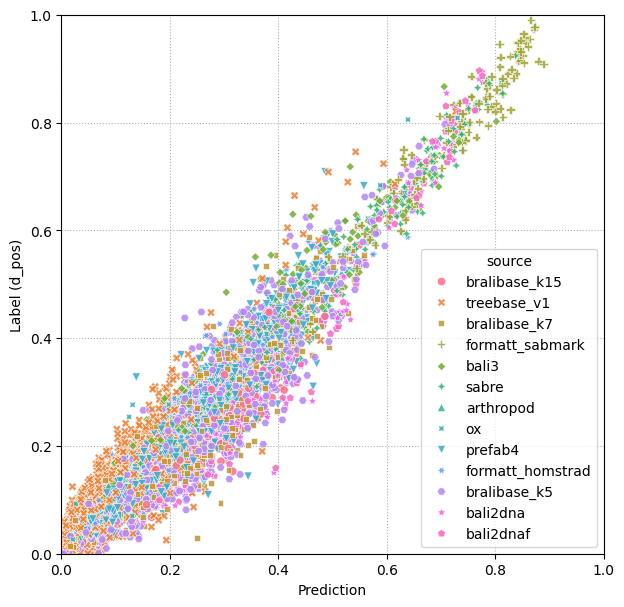

In [38]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[train_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 7))
sn.scatterplot(x=y_pred, y=y_true, alpha=0.85, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

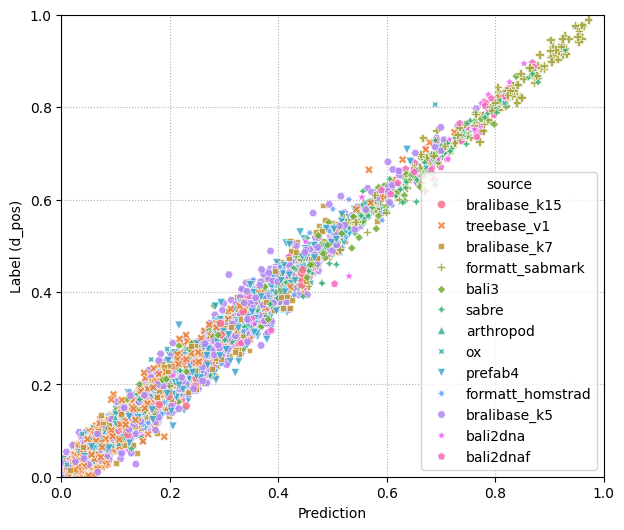

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[train_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 6))
sn.scatterplot(
    x=model.predict(feat_df.loc[train_idxs]),
    y=labels.loc[train_idxs].to_numpy().ravel(),
    alpha=0.85,
    style=sources,
    hue=sources,
)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )